In [8]:
# Description: This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM)
#            to predict the closing stock price using the past 60 minutes stock price.
#            "Close" price is only considered for learning and predicting model

In [9]:
# Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [10]:
#Make a data frame using all files
import datetime
path = 'data/'
all_files = glob.glob(path + "/*.csv")

dates = [datetime.datetime.strptime(ts[10:18], "%Y%m%d") for ts in all_files]
dates.sort()
sorteddates = [datetime.datetime.strftime(ts, "%Y%m%d") for ts in dates]
sorteddatesfiles=[]
for k in range(len(sorteddates)):
    sorteddatesfiles.append('data/AAPL-'+sorteddates[k]+'.csv')

li = []

for filename in sorteddatesfiles:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df

,index,DateTime,Open,Close,High,Low,Volume,Previous_Close,MA5_Close,MA9_Close,...,bb_bbhi_20,bb_bbli_20,bb_bbw_20,bb_bbp_20,atr_14,accDistIndexIndicator,forceIndexIndicator,mfi,vwap,trend
0,0,2019-12-16 09:30:00-05:00,69.25,69.27,69.34,69.25,25835,68.82,69.25,69.27,...,0.0,0.0,0.000000,0.000000,0.000000,-14.352778,0.000000,0.000000,0.678097,up
1,1,2019-12-16 09:31:00-05:00,69.27,69.32,69.33,69.25,6655,68.82,69.26,69.29,...,0.0,0.0,0.144311,0.750000,0.000000,-9.361528,332.750000,50.000000,0.682066,up
2,2,2019-12-16 09:32:00-05:00,69.33,69.39,69.49,69.33,9916,68.82,69.28,69.33,...,0.0,0.0,0.283966,0.821711,0.000000,-11.840528,384.374286,50.000000,0.720779,up
3,3,2019-12-16 09:33:00-05:00,69.40,69.53,69.53,69.39,9694,68.82,69.31,69.38,...,0.0,0.0,0.563987,0.889747,0.000000,-2.146528,523.343673,50.000000,0.766009,up
4,4,2019-12-16 09:34:00-05:00,69.52,69.46,69.54,69.44,11499,68.82,69.35,69.39,...,0.0,0.0,0.539005,0.676453,0.000000,-9.045928,333.590292,19.528000,0.800907,up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87119,385,2020-11-03 15:55:00-05:00,111.06,110.69,111.09,110.69,5771,108.77,110.93,110.90,...,0.0,0.0,0.561303,0.048872,0.217325,43.335360,-260.873952,-4.015618,1.975775,down
87120,386,2020-11-03 15:56:00-05:00,110.70,110.70,110.74,110.52,5402,108.77,110.92,110.88,...,0.0,0.0,0.599499,0.115142,0.217682,46.772996,-215.889101,-3.733499,1.944018,down
87121,387,2020-11-03 15:57:00-05:00,110.71,110.62,110.83,110.57,4404,108.77,110.89,110.85,...,0.0,0.0,0.652743,0.062924,0.223324,44.062842,-235.379230,4.042471,1.921440,down
87122,388,2020-11-03 15:58:00-05:00,110.62,110.50,110.67,110.45,6089,108.77,110.83,110.80,...,0.0,1.0,0.714135,-0.010727,0.222881,40.741570,-306.136483,1.448536,1.890211,down


In [11]:
# The avove data is large. So I only conser couple of files 
df = pd.concat(map(pd.read_csv, ['data/AAPL-20201028.csv', 'data/AAPL-20201029.csv', 'data/AAPL-20201030.csv', 'data/AAPL-20201102.csv','data/AAPL-20201103.csv']))
df

,index,DateTime,Open,Close,High,Low,Volume,Previous_Close,MA5_Close,MA9_Close,...,bb_bbhi_20,bb_bbli_20,bb_bbw_20,bb_bbp_20,atr_14,accDistIndexIndicator,forceIndexIndicator,mfi,vwap,trend
0,0,2020-10-28 09:30:00-04:00,115.04,115.12,115.43,114.73,19056,116.53,115.04,115.12,...,0.0,0.0,0.000000,0.000000,0.000000,2.177829,0.000000,0.000000,-1.232873,down
1,1,2020-10-28 09:31:00-04:00,115.12,114.82,115.27,114.73,4297,116.53,115.08,114.97,...,0.0,0.0,0.521875,0.250000,0.000000,-0.686838,-1289.100000,-50.000000,-1.257084,down
2,2,2020-10-28 09:32:00-04:00,114.83,114.44,114.92,114.40,6626,116.53,115.00,114.79,...,0.0,0.0,0.969563,0.182538,0.000000,-6.293453,-1464.640000,-50.000000,-1.347832,down
3,3,2020-10-28 09:33:00-04:00,114.42,114.34,114.42,114.09,5624,116.53,114.85,114.68,...,0.0,0.0,1.084079,0.226517,0.000000,-3.396241,-1335.748571,-50.000000,-1.439474,down
4,4,2020-10-28 09:34:00-04:00,114.32,114.08,114.33,113.91,4362,116.53,114.75,114.56,...,0.0,0.0,1.282333,0.173256,0.000000,-4.227099,-1306.944490,-50.000000,-1.509338,down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,385,2020-11-03 15:55:00-05:00,111.06,110.69,111.09,110.69,5771,108.77,110.93,110.90,...,0.0,0.0,0.561303,0.048872,0.217325,43.335360,-260.873952,-4.015618,1.975775,down
386,386,2020-11-03 15:56:00-05:00,110.70,110.70,110.74,110.52,5402,108.77,110.92,110.88,...,0.0,0.0,0.599499,0.115142,0.217682,46.772996,-215.889101,-3.733499,1.944018,down
387,387,2020-11-03 15:57:00-05:00,110.71,110.62,110.83,110.57,4404,108.77,110.89,110.85,...,0.0,0.0,0.652743,0.062924,0.223324,44.062842,-235.379230,4.042471,1.921440,down
388,388,2020-11-03 15:58:00-05:00,110.62,110.50,110.67,110.45,6089,108.77,110.83,110.80,...,0.0,1.0,0.714135,-0.010727,0.222881,40.741570,-306.136483,1.448536,1.890211,down


In [12]:
#Get the number of rows and columns
df.shape

(1950, 65)

Text(0, 0.5, 'Close Price')

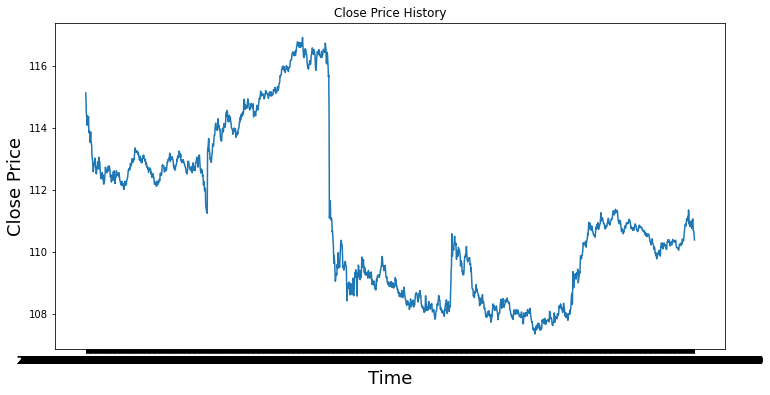

In [13]:
#visualize the closing price history
plt.figure(figsize=(12,6))
plt.title('Close Price History')
plt.plot(df['DateTime'],df['Close'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Close Price', fontsize=18)

In [15]:
#Create a new dataframe with only the Close column
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

1560

In [16]:
data_y = df.filter(['trend'])
data_y = np.array(data_y)
data_y_binary =[]
for k in data_y:
    if k == 'down':
        data_y_binary.append(0)
    else:
        data_y_binary.append(1)
        

In [17]:
#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.81276151],
       [0.78138075],
       [0.7416318 ],
       ...,
       [0.34205021],
       [0.32949791],
       [0.31694561]])

In [18]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
#split the data into X_train and y_train data sets
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(data_y_binary[i])
    if i<= 60:
        print(X_train)
        print(y_train)
        print()

[array([0.81276151, 0.78138075, 0.7416318 , 0.73117155, 0.7039749 ,
       0.73640167, 0.72175732, 0.72280335, 0.7290795 , 0.7332636 ,
       0.67887029, 0.68096234, 0.68410042, 0.67364017, 0.64644351,
       0.67468619, 0.68096234, 0.65167364, 0.64016736, 0.63493724,
       0.60146444, 0.59205021, 0.58158996, 0.55962343, 0.54707113,
       0.55543933, 0.57112971, 0.57635983, 0.57949791, 0.58891213,
       0.59309623, 0.56694561, 0.56276151, 0.54288703, 0.53974895,
       0.55020921, 0.56276151, 0.56276151, 0.58054393, 0.57845188,
       0.58263598, 0.55648536, 0.59623431, 0.58158996, 0.58158996,
       0.58054393, 0.55020921, 0.54393305, 0.52405858, 0.52405858,
       0.53556485, 0.52824268, 0.53556485, 0.54497908, 0.52196653,
       0.53661088, 0.52719665, 0.50627615, 0.50523013, 0.52615063])]
[1]



In [19]:
#Convert the X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [20]:
#Reshape the dataX_train.shape
X_train.shape
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_train.shape

(1500, 60, 1)

In [21]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [22]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
#Train the model
model.fit(X_train, y_train, batch_size = 1, epochs = 2)

Epoch 1/2
1500/1500 [==============================] - 21s 14ms/step - loss: 0.2534
Epoch 2/2
1500/1500 [==============================] - 21s 14ms/step - loss: 0.2466


In [24]:
# Create the testing data set
# Create a new array containing scaled values
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets X_test and y_test
X_test = []
#y_test = dataset[training_data_len:, :]
y_test = data_y_binary[training_data_len: ]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

In [25]:
#Convert the data to a numpy array
X_test = np.array(X_test)

In [26]:
#Reshaoe the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [27]:
#Get the models predicted price values
predictions = model.predict(X_test)
predictions

array([[0.3642199 ],
       [0.36914235],
       [0.37254137],
       [0.37364447],
       [0.37401184],
       [0.37469178],
       [0.37620693],
       [0.3779384 ],
       [0.3796835 ],
       [0.38051075],
       [0.3804796 ],
       [0.38005438],
       [0.3805073 ],
       [0.38135564],
       [0.38207906],
       [0.38244864],
       [0.38358235],
       [0.3839147 ],
       [0.38224173],
       [0.38077357],
       [0.38004053],
       [0.3801267 ],
       [0.3811436 ],
       [0.38204262],
       [0.384285  ],
       [0.38826278],
       [0.39201468],
       [0.39496785],
       [0.39656487],
       [0.39766744],
       [0.39862186],
       [0.39965802],
       [0.4008557 ],
       [0.40263596],
       [0.40522897],
       [0.407265  ],
       [0.40876722],
       [0.40970743],
       [0.41018254],
       [0.41067776],
       [0.41119114],
       [0.41190884],
       [0.4120814 ],
       [0.41136438],
       [0.4110538 ],
       [0.41154036],
       [0.4125355 ],
       [0.413

In [29]:
prediction_diff = predictions[0:-1]-predictions[1:]
updown = [] 
updown.append(predictions[0][0])

for i in range(len(prediction_diff)):
    if prediction_diff[i] > 0: 
        updown.append(1)
    else:
        updown.append(0)
predictions = updown        

In [30]:
#Evaluate the model using root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

TypeError: unsupported operand type(s) for -: 'list' and 'list'

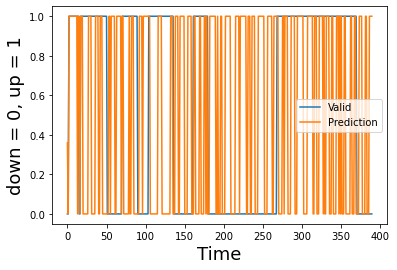

In [230]:
#Plot the data
train = data_y_binary[:training_data_len]
valid = data_y_binary[training_data_len:]
plt.plot(valid)
plt.plot(predictions)
plt.xlabel('Time', fontsize=18)
plt.ylabel('down = 0, up = 1', fontsize=18)
plt.legend(['Valid', 'Prediction'])

In [232]:
matchsum = 0
for ind in range(len(valid)):
    if valid[ind] == predictions[ind]:
        matchsum = matchsum+1
accuracy = 100*matchsum/len(valid)  
accuracy

42.56410256410256